# **BiLSTM with character level information and extra CRF Layer**

In [2]:
import os
# print(f'Current working directory: {os.getcwd()}')
# parent_dir = os.path.dirname(os.getcwd())
# print(f'Parent directory: {parent_dir}')
# os.chdir(parent_dir)
# print(f'Current working directory: {os.getcwd()}')
# # see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload

# # notebook will reload external python modules;
# %autoreload 2 

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from datasets import load_dataset
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tf2crf import CRF, ModelWithCRFLoss
from transformers import BertTokenizerFast, TFAutoModel

from bilstm_models import *

In [4]:
dataset = load_dataset('conll2003')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
# Define label2token and token2label mappings
label2token = {
    'O': 0,
    'B-PER': 1,
    'I-PER': 2,
    'B-ORG': 3,
    'I-ORG': 4,
    'B-LOC': 5,
    'I-LOC': 6,
    'B-MISC': 7,
    'I-MISC': 8,
    '[PAD]': 10 
}
token2label = {token: label for label, token in label2token.items()}

# Process the dataset
tokenized_datasets = dataset.map(tokenize_and_align_labels)
tokenized_datasets.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'labels', 'char_encoded_tokens'])

# check the first example in the dataset
example = tokenized_datasets['train'][0]
input_ids = example['input_ids'].numpy()
sentence = tokenizer.decode(input_ids)
print("Original Sentence:")
print(sentence)
labels = example['labels'].numpy()
print("\nLabels Before Transformation:")
print(labels)
labels = labels[labels != 10]
reconstructed_labels = [token2label[token] for token in labels]
print("\nLabels After Transformation:")
print(reconstructed_labels)

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Original Sentence:
[CLS] EU rejects German call to boycott British lamb. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

Labels Before Transformation:
[10  3  0  7  0  0  0  7  0  0  0 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10

In [5]:
def prepare_dataset(tokenized_data, shuffle=False, cache=True):
  AUTOTUNE = tf.data.experimental.AUTOTUNE
  column_names = ['input_ids', 'attention_mask', 'labels', 'char_encoded_tokens']
  print(f"\t preparing {tokenized_data} dataset ... ", flush=True)
  dataset = tf.data.Dataset.from_tensor_slices((
      {key: np.array(tokenized_datasets[tokenized_data][key]) for key in column_names},
      np.array(tokenized_datasets[tokenized_data]['labels'])
  ))

  if cache:
      dataset = dataset.cache()
  if shuffle:
      dataset = dataset.shuffle(1000)
  dataset = dataset.batch(32, drop_remainder=True)
  dataset = dataset.prefetch(AUTOTUNE)
  return dataset

In [6]:

train_dataset = prepare_dataset('train', shuffle=True)
validation_dataset = prepare_dataset('validation')
test_dataset = prepare_dataset('test')

print(f"train dataset size: {len(tokenized_datasets['train'])}")
print(f"validation dataset size: {len(tokenized_datasets['validation'])}")
print(f"test dataset size: {len(tokenized_datasets['test'])}")

print(f"{tokenized_datasets['train'][0].keys()}")

print(f"input_ids shape: {tokenized_datasets['train'][0]['input_ids'].shape}")
# print(tokenized_datasets['train'][0]['input_ids'])

print(f"attention maske shape: {tokenized_datasets['train'][0]['attention_mask'].shape}")
# print(tokenized_datasets['train'][0]['attention_mask'])

print(f"labels shape: {tokenized_datasets['train'][0]['labels'].shape}")
# print(tokenized_datasets['train'][0]['labels'])

print(f"tokenised train dataset shape: {tokenized_datasets['train'][0]['char_encoded_tokens'].shape}")
# print(tokenized_datasets['train'][0]['char_encoded_tokens'])

	 preparing train dataset ... 
	 preparing validation dataset ... 
	 preparing test dataset ... 
train dataset size: 14041
validation dataset size: 3250
test dataset size: 3453
dict_keys(['input_ids', 'attention_mask', 'labels', 'char_encoded_tokens'])
input_ids shape: (128,)
attention maske shape: (128,)
labels shape: (128,)
tokenised train dataset shape: (128, 2)


### character embedding

In [8]:
input_data, labels, sample_weights = prepare_inputs(train_dataset)

# Take one example from the input_data to showcase
input_ids_example, attention_mask_example, char_embed_example = input_data[0][0], input_data[1][0], input_data[2][0]
labels_example = labels[0]
weights_example = sample_weights[0]

# Decode the input_ids_example back to words  
words = tokenizer.convert_ids_to_tokens(input_ids_example)

# Display the first word, its input_ids, attention_mask, char_embed, label and sample_weight
print(f"Word: {words[0]}")
print(f"Input IDs: {input_ids_example[0]}")
print(f"Attention Mask: {attention_mask_example[0]}")
print(f"Char Embedding: {char_embed_example[0]}")
print(f"Label: {labels_example[0]}")
print(f"Sample Weight: {weights_example[0]}")

x_train, y_train, sample_weights_train = prepare_inputs(train_dataset)
x_test, y_test, sample_weights_test = prepare_inputs(test_dataset)
x_val, y_val, sample_weights_val = prepare_inputs(validation_dataset)

Word: [CLS]
Input IDs: 101
Attention Mask: 1
Char Embedding: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Label: 10
Sample Weight: 0.0


In [9]:

LOAD_MODEL = False
EPOCHS = 20
BATCH_SIZE = 75
num_chars = len(char2idx) # The number of unique characters
hidden_units = 96  # The number of hidden units for LSTM layers
unique_labels = set([tag for sentence in dataset["train"]["ner_tags"] for tag in sentence])
num_classes = len(unique_labels)+1
word_embedding_dim = 64  # The dimension of word embedding
char_embed_dim = 20  # The dimension of character embedding
vocab_size = len(tokenizer.get_vocab())  # Size of the vocabulary

max_seq_len = 128  # Maximum number of words in a sequence
max_word_len = 128  # Maximum number of characters in a word



# prepare training data
x_train_padded = [pad_sequences(x, maxlen=max_seq_len, padding="post", value=vocab_size) for x in x_train]

# y_train_encoded = [[label + 1 for label in seq] for seq in y_train]  # Shift labels to [1, 10]
y_train_new = pad_sequences(y_train, maxlen=max_seq_len, padding="post", value=10)  # Use 0 for padding

x_val_padded = [pad_sequences(x, maxlen=max_seq_len, padding="post", value=vocab_size) for x in x_val]
# y_val_encoded = [[label + 1 for label in seq] for seq in y_val]
y_val_new = pad_sequences(y_val, maxlen=max_seq_len, padding="post", value=10)  # Use 0 for padding

# only word
x_train_nochar = [x_train_padded[0],x_train_padded[1]]
x_val_nochar = [x_val_padded[0],x_val_padded[1]]


print(f"\n\n \t\t\t creating and training model ... \n\n")

# ----------------- pre trained embedding
# Load DistilBERT
distilbert_model = TFAutoModel.from_pretrained('distilbert-base-uncased')
distilbert_model.trainable = False

# Character embedding
print(f"creating character embedding ... ")
char_input = layers.Input(shape=(max_seq_len, max_word_len), dtype='int32')

char_embed = layers.TimeDistributed(layers.Embedding(num_chars, char_embed_dim, mask_zero=True))(char_input)

char_bilstm = layers.TimeDistributed(layers.Bidirectional(layers.LSTM(hidden_units)))(char_embed)

# Word-level input
print(f"creating word-level input ... ")
word_input = layers.Input(shape=(max_seq_len,), dtype='int32')
attention_mask_input = layers.Input(shape=(max_seq_len,), dtype='int32')

# Word Embedding
print(f"creating word embedding ... ")
# word_embedding = layers.Embedding(input_dim=vocab_size, output_dim=word_embedding_dim)(word_input)
word_embedding = distilbert_model([word_input, attention_mask_input])[0] # with distilbert

# Concatenate word and char-level information
print(f"concatenating word and char-level information ... ")
combined = layers.Concatenate()([word_embedding, char_bilstm])

# Final BiLSTM layer for sequence tagging
print(f"final BiLSTM layer for sequence tagging ... ")
bilstm = layers.Bidirectional(layers.LSTM(hidden_units, return_sequences=True))(combined)

# for word embedding only
# bilstm = layers.Bidirectional(layers.LSTM(hidden_units, return_sequences=True,
#                                           kernel_initializer='he_normal'))(word_embedding)


# Final BiLSTM layer for sequence tagging
dropout = layers.Dropout(0.5)(bilstm)

# Add CRF layer
crf = CRF(num_classes+1)  # Plus 1 for the padding class
output = crf(dropout)                                         


base_model = tf.keras.Model(inputs=[word_input, attention_mask_input, char_input], outputs=output) # char info
# base_model = tf.keras.Model(inputs=[word_input, attention_mask_input], outputs=output) #no char info
model = ModelWithCRFLoss(base_model)


class_weights = {i: 1 for i in range(num_classes)}
class_weights[10] = 0  # Set the weight for the padding label to 0



print(f"COMPILING MODEL ... ")

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

if LOAD_MODEL == True:
  model.load_weights('./models/checkpoints/bilstm_crf_model_checkpoint.h5')
else:
  checkpoint = ModelCheckpoint('model_checkpoint.h5',
                             verbose=1, save_best_only=True, mode='min',
                             save_weights_only=True)


# Training
print(f"TRAINING MODEL ... ")
early_stopping = EarlyStopping(monitor='val_loss_val', patience=3, restore_best_weights=True)

# get maximum workers from cpu
import multiprocessing
USE_MP = True
workers = multiprocessing.cpu_count()

if USE_MP == True:
  history = model.fit(x_train_padded, y_train_new,
                      validation_data = (x_val_padded,y_val_new),
                      epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks = [checkpoint, early_stopping], 
                      use_multiprocessing=USE_MP, workers=workers-3)
else:
  history = model.fit(x_train_padded, y_train_new,
                    validation_data = (x_val_padded,y_val_new),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks = [checkpoint, early_stopping])

# history = model.fit(x_train_nochar, y_train,
#                     validation_data = (x_val_nochar,y_val),
#                     epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks = [checkpoint, early_stopping])




 			 creating and training model ... 




Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


creating character embedding ... 
creating word-level input ... 
creating word embedding ... 
concatenating word and char-level information ... 
final BiLSTM layer for sequence tagging ... 
COMPILING MODEL ... 
TRAINING MODEL ... 
Epoch 1/20
187/187 [==============================] - ETA: 0s - loss: 22.3357 - accuracy: 0.6833

187/187 [==============================] - 198s 915ms/step - loss: 22.3357 - accuracy: 0.6833 - val_loss_val: 21.2316 - val_val_accuracy: 0.7160
Epoch 2/20
187/187 [==============================] - ETA: 0s - loss: 17.0631 - accuracy: 0.7161

187/187 [==============================] - 163s 872ms/step - loss: 17.0631 - accuracy: 0.7161 - val_loss_val: 16.6410 - val_val_accuracy: 0.7301
Epoch 3/20
187/187 [==============================] - ETA: 0s - loss: 14.4139 - accuracy: 0.7368

187/187 [==============================] - 163s 872ms/step - loss: 14.4139 - accuracy: 0.7368 - val_loss_val: 14.6999 - val_val_accuracy: 0.7503
Epoch 4/20
187/187 [==============================] - ETA: 0s - loss: 12.7863 - accuracy: 0.7686

187/187 [==============================] - 163s 874ms/step - loss: 12.7863 - accuracy: 0.7686 - val_loss_val: 13.2635 - val_val_accuracy: 0.8034
Epoch 5/20
187/187 [==============================] - ETA: 0s - loss: 11.5762 - accuracy: 0.8138

187/187 [==============================] - 164s 876ms/step - loss: 11.5762 - accuracy: 0.8138 - val_loss_val: 12.1850 - val_val_accuracy: 0.8260
Epoch 6/20
187/187 [==============================] - ETA: 0s - loss: 10.6862 - accuracy: 0.8315

187/187 [==============================] - 162s 868ms/step - loss: 10.6862 - accuracy: 0.8315 - val_loss_val: 11.4302 - val_val_accuracy: 0.8377
Epoch 7/20
187/187 [==============================] - ETA: 0s - loss: 9.9949 - accuracy: 0.8438

187/187 [==============================] - 162s 869ms/step - loss: 9.9949 - accuracy: 0.8438 - val_loss_val: 10.8631 - val_val_accuracy: 0.8438
Epoch 8/20
187/187 [==============================] - ETA: 0s - loss: 9.4371 - accuracy: 0.8528

187/187 [==============================] - 164s 875ms/step - loss: 9.4371 - accuracy: 0.8528 - val_loss_val: 10.3102 - val_val_accuracy: 0.8546
Epoch 9/20
187/187 [==============================] - ETA: 0s - loss: 8.9502 - accuracy: 0.8618

187/187 [==============================] - 164s 877ms/step - loss: 8.9502 - accuracy: 0.8618 - val_loss_val: 9.9938 - val_val_accuracy: 0.8595
Epoch 10/20
187/187 [==============================] - ETA: 0s - loss: 8.5654 - accuracy: 0.8688

187/187 [==============================] - 164s 876ms/step - loss: 8.5654 - accuracy: 0.8688 - val_loss_val: 9.5253 - val_val_accuracy: 0.8670
Epoch 11/20
187/187 [==============================] - ETA: 0s - loss: 8.2098 - accuracy: 0.8745

187/187 [==============================] - 163s 874ms/step - loss: 8.2098 - accuracy: 0.8745 - val_loss_val: 9.2774 - val_val_accuracy: 0.8696
Epoch 12/20
187/187 [==============================] - ETA: 0s - loss: 7.8858 - accuracy: 0.8798

187/187 [==============================] - 163s 872ms/step - loss: 7.8858 - accuracy: 0.8798 - val_loss_val: 9.0007 - val_val_accuracy: 0.8739
Epoch 13/20
187/187 [==============================] - ETA: 0s - loss: 7.6049 - accuracy: 0.8859

187/187 [==============================] - 163s 870ms/step - loss: 7.6049 - accuracy: 0.8859 - val_loss_val: 8.7699 - val_val_accuracy: 0.8814
Epoch 14/20
187/187 [==============================] - ETA: 0s - loss: 7.3606 - accuracy: 0.8903

187/187 [==============================] - 163s 870ms/step - loss: 7.3606 - accuracy: 0.8903 - val_loss_val: 8.5178 - val_val_accuracy: 0.8843
Epoch 15/20
187/187 [==============================] - ETA: 0s - loss: 7.1123 - accuracy: 0.8942

187/187 [==============================] - 163s 871ms/step - loss: 7.1123 - accuracy: 0.8942 - val_loss_val: 8.2927 - val_val_accuracy: 0.8854
Epoch 16/20
187/187 [==============================] - ETA: 0s - loss: 6.8906 - accuracy: 0.8976

187/187 [==============================] - 164s 875ms/step - loss: 6.8906 - accuracy: 0.8976 - val_loss_val: 8.1911 - val_val_accuracy: 0.8875
Epoch 17/20
187/187 [==============================] - ETA: 0s - loss: 6.6769 - accuracy: 0.9002

187/187 [==============================] - 163s 870ms/step - loss: 6.6769 - accuracy: 0.9002 - val_loss_val: 8.0289 - val_val_accuracy: 0.8906
Epoch 18/20
187/187 [==============================] - ETA: 0s - loss: 6.4969 - accuracy: 0.9026

187/187 [==============================] - 163s 870ms/step - loss: 6.4969 - accuracy: 0.9026 - val_loss_val: 7.7381 - val_val_accuracy: 0.8938
Epoch 19/20
187/187 [==============================] - ETA: 0s - loss: 6.3192 - accuracy: 0.9049

187/187 [==============================] - 163s 872ms/step - loss: 6.3192 - accuracy: 0.9049 - val_loss_val: 7.5771 - val_val_accuracy: 0.8946
Epoch 20/20
187/187 [==============================] - ETA: 0s - loss: 6.1064 - accuracy: 0.9126

187/187 [==============================] - 163s 873ms/step - loss: 6.1064 - accuracy: 0.9126 - val_loss_val: 7.4530 - val_val_accuracy: 0.9009
Epoch 1/20
187/187 [==============================] - ETA: 0s - loss: 5.9659 - accuracy: 0.9166

187/187 [==============================] - 163s 874ms/step - loss: 5.9659 - accuracy: 0.9166 - val_loss_val: 7.5186 - val_val_accuracy: 0.8980
Epoch 2/20
 74/187 [==========>...................] - ETA: 1:33 - loss: 6.0454 - accuracy: 0.9157

KeyboardInterrupt: ignored

In [15]:

# model.save_weights('bilstm_crf_final_model_weights')
model.save_weights('./bilstm_final_weights')


### Testing

In [11]:
x_test_padded = [pad_sequences(x, maxlen=max_seq_len, padding="post", value=vocab_size) for x in x_test]
y_test_new = pad_sequences(y_test, maxlen=max_seq_len, padding="post", value=10)  
x_test_nochar = [x_test_padded[0],x_test_padded[1]]


In [12]:
evaluate_model(model, x_test_padded, y_test_new, crf_model=True)

107/107 [==============================] - 20s 144ms/step
              precision    recall  f1-score   support

       B-LOC       0.63      0.66      0.64      2985
      B-MISC       0.50      0.40      0.44      1246
       B-ORG       0.69      0.59      0.63      3479
       B-PER       0.68      0.68      0.68      2974
       I-LOC       0.55      0.43      0.48       413
      I-MISC       0.35      0.26      0.30       319
       I-ORG       0.56      0.56      0.56      1295
       I-PER       0.79      0.87      0.83      2702
           O       0.96      0.97      0.97     47529

    accuracy                           0.89     62942
   macro avg       0.63      0.60      0.61     62942
weighted avg       0.89      0.89      0.89     62942



### Plotting

KeyError: ignored

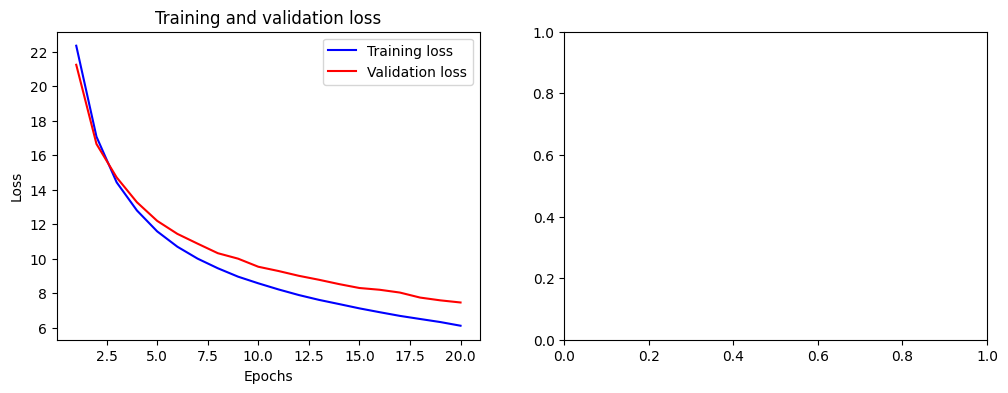

In [13]:
plot_training(history, crf_model=True)